
# CAM Tutorial (GoogLeNet, ImageNet)

This notebook demonstrates **Class Activation Mapping (CAM)** in the original, simple sense: **convolutions → global average pooling (GAP) → linear → softmax**. We use torchvision.models.googlenet pretrained on ImageNet, which fits the CAM requirement naturally.

**What you'll learn** (20 minutes)
- Load a pretrained ImageNet model with a GAP head.
- Hook the **feature maps before GAP** and read the **linear classifier weights**.
- Compute a **class activation map** for the predicted class (or a chosen class).
- Overlay the CAM on the input image for visualization.


<img src="./static/cam.jpg" alt="LO1 Image" style="width: 50%; height: auto;">  

In [9]:
# Import necessary libraries
import os # For file path operations
import torch # For tensor operations and deep learning
import numpy as np # For numerical operations
import torch.nn as nn # For neural network layers
from PIL import Image # For image processing
from torchvision import models, transforms # For pre-trained models and image transformations
import torch.nn.functional as F # For functional operations
from utils import denormalize, overlay_cam_on_image # For image denormalization and CAM overlay
import matplotlib.pyplot as plt

# Use CPU by default since no training is being done
device = torch.device('cpu')

### 1. Loading the Pre-trained Model

In [2]:
# Load pretrained GoogLeNet (ImageNet). It already uses conv → GAP → linear and has been trained on ImageNet (1000 classes)
googlenet_weights = models.GoogLeNet_Weights.IMAGENET1K_V1 # pretrained weights for GoogLeNet v1
model = models.googlenet(weights=googlenet_weights) # load the model
model.eval().to(device); # set to evaluation mode and move to device

We just loaded this model: GoogLeNet Architecture. Intermediate output predictions are used to counteract the vanishing gradient problem of very deep NNs. Perfect architecture because of Conv into GAP into Softmax.  

<img src="./static/GoogLeNet.png" alt="LO1 Image" style="width: 90%; height: auto;">  

### 2. Setting Up a "Hook" to Capture Feature Maps

How do we get the output of an intermediate layer? When we run model(image), we only get the final output. We need a way to "spy" on the data as it flows through the network. This is what a PyTorch **hook** is used for. A hook is like a little function you can attach to any layer in your model. When the forward pass happens, your hook function is automatically called, and it gets access to the layer's input and output.

In [3]:
# We will hook the input to model.avgpool (i.e., the final feature maps before GAP)
feature_maps = None

# This is our "spy" function. PyTorch will automatically pass it three arguments:
# module: The layer the hook is attached to (in this case, model.avgpool).
# input: A tuple containing the tensor(s) going into the layer.
# output: The tensor coming out of the layer.

def hook_feature_maps(module, input, output):
    # input is a tuple; take the tensor prior to GAP
    global feature_maps # The feature_maps variable was created outside the function. To modify it from inside the function, we must tell Python it's a global variable
    feature_maps = input[0].detach()  # [B, C, H, W]  Since input is a tuple, we take the first element [0], which is the tensor of feature maps.

# This is the line that actually attaches our hook_feature_maps function to the model.avgpool layer. 
# The hook_handle is an object that we can use later to remove the hook when we're done with it (hook_handle.remove()).
hook_handle = model.avgpool.register_forward_hook(hook_feature_maps)

### 3. Getting the Weights

In [4]:
# The linear classifier weights (shape [num_classes, C])

# This directly accesses the weights of the final fully connected (linear) layer, which is named fc in the GoogLeNet model. 
# This tensor has a shape of (number of classes, number of input features), which for ImageNet is (1000, 1024)
fc_weight = model.fc.weight.detach().cpu().numpy()

 # The googlenet_weights object we created earlier contains metadata, including the human-readable names for all 1000 ImageNet classes
 # You can look at what the model should be capable of classifying by inspecting these class names.
class_names = googlenet_weights.meta.get('categories', None);

print('Classifier weight shape:', fc_weight.shape) # here 1024 is the number of input features to the classifier

Classifier weight shape: (1000, 1024)


### 4. Transform the image to be compatible with the model 

In [5]:
# Image preprocessing for ImageNet compatibility
preprocess = transforms.Compose([
    transforms.Resize(256), # shorter side resized to 256
    transforms.CenterCrop(224), # center crop to 224x224
    transforms.ToTensor(), # convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]), # normalize with ImageNet stats
])

### 5. CAM computation: 
$\text{CAM}_c(x, y) = \sum_k w_{c,k} * F_k(x, y)$

In [6]:
# feature_maps captured by our hook: [1, C, H, W]
# fc_weight: [num_classes, C]
# class_idx: int, target class. If None, uses the model's top-1 prediction.

def compute_cam_for_class(fmaps: torch.Tensor, class_idx: int, fc_weight: np.ndarray):

    # 1. Get the dimensions of the feature maps
    C, H, W = fmaps.shape[1:] 

    # 2. Get the weights for our target class and reshape them for broadcasting
    w = torch.from_numpy(fc_weight[class_idx]).view(C, 1, 1)  # [C,1,1] 

    # 3. Compute the weighted sum of feature maps
    # PyTorch will automatically "stretch" the 1x1 dimensions of the weights to match the HxW dimensions of the feature maps,
    # allowing for a clean element-wise multiplication.
    cam = torch.sum(fmaps[0] * w.to(fmaps.device), dim=0)     # [H,W] , 0 because we take the first and only image from the batch

    # 4. Apply ReLU to keep only positive contributions
    # We are interested in the features that have a positive influence on the classification. 
    # We want to see the evidence that supports the class prediction, not what contradicts it.
    cam = F.relu(cam)
    
    # 5. Normalize the heatmap to be in the [0, 1] range for visualization
    cam = cam - cam.min()
    if cam.max() > 0:
        cam = cam / cam.max()
        
    return cam.cpu().numpy()  # [H,W] 

### 6. Provide your own image here and calculate the models attention

In [7]:
# keep images reasonably sized; preprocessing will center-crop to 224x224.
path = "../data/dog.jpg"

# Load and preprocess image
orig_img = Image.open(path).convert('RGB')
x = preprocess(orig_img).unsqueeze(0).to(device)  # [1,3,224,224]

# Forward pass through the model to get predictions (no grad needed)
with torch.no_grad():
    logits = model(x) # n.b., feature_maps is captured by the hook here, since we declared it as global feature_maps now exists
    probs = torch.softmax(logits, dim=1)[0] # [100b0]
    top_prob, top_idx = probs.max(dim=0) # get the top-1 class and its probability
    
# Compute CAM for predicted class (top-1)
fmap = feature_maps  # [1,C,h,w], thanks to our hook and since we declared it as global feature_maps now exists
cam = compute_cam_for_class(fmap, int(top_idx.item()), fc_weight) # calculation takes in fmaps, indx, weights

### 7. Visualize result

Top-1: Labrador retriever (p=0.732)


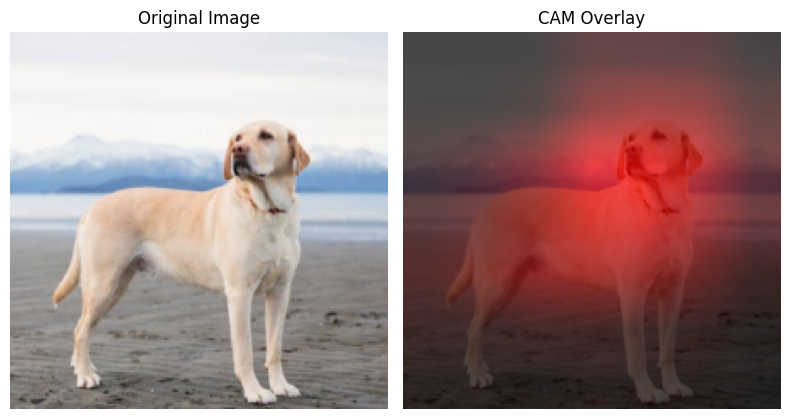

In [8]:
x_denorm = denormalize(x[0].cpu())
overlay = overlay_cam_on_image(x_denorm, cam, alpha=0.7) # n.b., this helper function interpolates the cam back to image size
# Titles
pred_name = class_names[int(top_idx)] if class_names is not None else str(int(top_idx))
print(f"Top-1: {pred_name} (p={float(top_prob):.3f})")
center_img = Image.fromarray((x_denorm.permute(1,2,0).numpy() * 255).astype('uint8'))

# Create a figure with 1 row and 2 columns for our subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 5))
# Display the original image on the first subplot (axes[0])
axes[0].imshow(center_img)
axes[0].set_title("Original Image")
axes[0].axis('off')  # Hide the x/y axes
# Display the CAM overlay on the second subplot (axes[1])
axes[1].imshow(overlay)
axes[1].set_title("CAM Overlay")
axes[1].axis('off')  # Hide the x/y axes
# Show the final plot, tight layout and close
plt.tight_layout()
plt.show()
plt.close()